# Model Comparison Notebook (v4)
This notebook compares a **PEFT‑fine‑tuned** model with its **base model** on any QA dataset, judges the answers with an OpenAI model, and can optionally save every prompt/answer/verdict to a CSV or JSONL file.

**What's new in v4**
* Outputs **separate counts** for **fine‑tuned wins**, **base wins**, and **ties** instead of a single tally.

⚠️ **Requirements** (uncomment the next cell to install if needed):
`pip install --upgrade openai datasets tqdm transformers peft pandas`

Make sure the environment variable `OPENAI_API_KEY` is set before running the _Judge_ step.

In [ ]:
# !pip install --upgrade openai datasets tqdm transformers peft pandas
# Uncomment ↑ if your environment does not have the required packages

In [ ]:

import os
import random
import json
from pathlib import Path
from typing import Dict, List, Tuple

import torch
from datasets import load_dataset
from tqdm import tqdm
from transformers import AutoModelForCausalLM, AutoTokenizer
from peft import PeftConfig, PeftModel

try:
    import pandas as pd
except ImportError:
    pd = None

try:
    from openai import OpenAI
except ImportError:
    OpenAI = None


# -----------------------------
# Helper functions
# -----------------------------

def load_models(checkpoint_path: str):
    """Load the base and PEFT‑finetuned models ready for generation."""
    peft_cfg = PeftConfig.from_pretrained(checkpoint_path)
    base_name = peft_cfg.base_model_name_or_path

    base_model = AutoModelForCausalLM.from_pretrained(base_name, trust_remote_code=True)
    tokenizer = AutoTokenizer.from_pretrained(base_name, trust_remote_code=True)
    tokenizer.pad_token = tokenizer.eos_token

    finetuned_model = PeftModel.from_pretrained(base_model, checkpoint_path)

    device = "cuda" if torch.cuda.is_available() else "cpu"
    base_model.to(device).eval()
    finetuned_model.to(device).eval()

    return tokenizer, base_model, finetuned_model, device


def generate(model, tokenizer, device, prompt: str, *, max_new_tokens: int = 200, temperature: float = 0.7, top_p: float = 0.9):
    """Generate a completion from a given model."""
    inputs = tokenizer(prompt, return_tensors="pt").to(device)
    with torch.no_grad():
        ids = model.generate(
            **inputs,
            max_new_tokens=max_new_tokens,
            do_sample=True,
            temperature=temperature,
            top_p=top_p,
            repetition_penalty=1.1,
            pad_token_id=tokenizer.eos_token_id,
        )
    return tokenizer.decode(ids[0], skip_special_tokens=True)


def judge(question: str, answer_a: str, answer_b: str, *, model_name: str = "gpt-3.5-turbo", max_tokens: int = 700) -> int:
    """Ask an OpenAI model which answer is better.

Returns +1 if *answer_a* is preferred, ‑1 if *answer_b* is preferred, 0 for a tie."""
    if OpenAI is None:
        raise RuntimeError("openai>=1.0 package not installed.  pip install --upgrade openai")

    if not os.getenv("OPENAI_API_KEY"):
        raise EnvironmentError("OPENAI_API_KEY env var not set.")

    client = OpenAI()
    system_prompt = """You are an impartial judge tasked with deciding which of two answers to the same question is superior.  Consider factual correctness, helpfulness, completeness, and clarity. "\ 
        "Your output should only be 'A' or 'B'." """   
    user_prompt = f""" "Question: {question}\n\n"        Answer A:\n{answer_a}\n\n    Answer B:\n{answer_b}\n\n       Which answer is better ?"""

    response = client.chat.completions.create(
        model=model_name,
        messages=[
            {"role": "system", "content": system_prompt},
            {"role": "user", "content": user_prompt},
        ],
        temperature=0,
        max_tokens=max_tokens,
    )
    verdict = response.choices[0].message.content.strip()
    return {"A": 1, "B": -1}.get(verdict, "not found")


def save_results(records: List[Dict[str, str]], path: Path):
    """Save the run details to CSV or JSONL depending on extension."""
    path = path.expanduser().resolve()
    path.parent.mkdir(parents=True, exist_ok=True)

    if path.suffix.lower() == ".jsonl":
        with open(path, "w", encoding="utf-8") as fp:
            for rec in records:
                fp.write(json.dumps(rec, ensure_ascii=False) + "\n")
    else:  # default CSV
        if pd is not None:
            import pandas as _pdpkg
            _pdpkg.DataFrame.from_records(records).to_csv(path, index=False)
        else:
            import csv
            with open(path, "w", newline="", encoding="utf-8") as fp:
                writer = csv.DictWriter(fp, fieldnames=records[0].keys())
                writer.writeheader()
                writer.writerows(records)


In [16]:
# -----------------------------
# Parameters (edit as desired)
# -----------------------------
checkpoint_path = "./phi2-finetuned/checkpoint-240500"  # path to PEFT checkpoint directory
dataset_name = "code_help_questions.jsonl"               # path to your JSONL file or HF dataset name
split = None                                              # ignored if dataset is a local JSONL
num_samples = 30                                      # number of questions to evaluate
judge_model = "gpt-4o"                                       # OpenAI model used for judging
max_tokens_judge = 700                                    # max tokens for judge completion
save_path = None  # e.g. "run_results.csv" or "run_results.jsonl"; set to None to skip saving


In [18]:
# -----------------------------
# Load data
# -----------------------------
if dataset_name and Path(dataset_name).is_file():
    with open(dataset_name, "r", encoding="utf-8") as fp:
        raw = [json.loads(line) for line in fp]
    questions = [item["question"] for item in raw if "question" in item][: num_samples]
else:
    if split is None:
        raise ValueError("'split' must be specified when using a HF dataset name")
    ds = load_dataset(dataset_name, split=split)
    questions = ds["question"][: num_samples]

random.shuffle(questions)
print(f"Loaded {len(questions)} questions.")

# -----------------------------
# Load models (this can take a while)
# -----------------------------
tokenizer, base_model, finetuned_model, device = load_models(checkpoint_path)
print("Models loaded → device:", device)


Loaded 30 questions.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Models loaded → device: cpu


In [ ]:
# -----------------------------
# Evaluate & print verdicts
# -----------------------------
ft_wins = 0
base_wins = 0
ties = 0
records = []

for idx, q in enumerate(tqdm(questions, desc="Evaluating")):
    prompt = f"### Prompt:\n{q}\n\n### Response:\n"
    answer_ft = generate(finetuned_model, tokenizer, device, prompt)
    answer_base = generate(base_model, tokenizer, device, prompt)

    try:
        outcome = judge(q, answer_ft, answer_base, model_name=judge_model, max_tokens=max_tokens_judge)
    except Exception as e:
        print(f"[WARN] Judge step failed ({{e}}) — counting as Tie")
        outcome = 0

    if outcome == 1:
        ft_wins += 1
        verdict_str = "FT"
    elif outcome == -1:
        base_wins += 1
        verdict_str = "BASE"
    else:
        ties += 1
        verdict_str = "Tie"

    print(f"Q{{idx+1:>3}}: {verdict_str}")

    records.append({
        "question": q,
        "answer_ft": answer_ft,
        "answer_base": answer_base,
        "verdict": verdict_str,
    })

print("\nFinished! Summary of outcomes:")
print(f"Fine‑tuned wins : {ft_wins}")
print(f"Base wins      : {base_wins}")
print(f"Ties           : {ties}")


Evaluating:  50%|█████     | 1/2 [02:46<02:46, 166.16s/it]

Q{idx+1:>3}: FT


Evaluating: 100%|██████████| 2/2 [05:37<00:00, 168.83s/it]

Q{idx+1:>3}: BASE

Finished! Summary of outcomes:
Fine‑tuned wins : 1
Base wins      : 1
Ties           : 0


In [14]:
# -----------------------------
# Evaluate & print verdicts
# -----------------------------
ft_wins = 0
base_wins = 0
ties = 0
records = []

for idx, q in enumerate(tqdm(questions, desc="Evaluating")):
    prompt = f"### Prompt:\n{q}\n\n### Response:\n"
    answer_ft = generate(finetuned_model, tokenizer, device, prompt)
    answer_base = generate(base_model, tokenizer, device, prompt)

    try:
        outcome = judge(q, answer_ft, answer_base, model_name=judge_model, max_tokens=max_tokens_judge)
    except Exception as e:
        print(f"[WARN] Judge step failed ({{e}}) — counting as Tie")
        outcome = 0

    if outcome == 1:
        ft_wins += 1
        verdict_str = "FT"
    elif outcome == -1:
        base_wins += 1
        verdict_str = "BASE"
    else:
        ties += 1
        verdict_str = "Tie"

    print(f"Q{{idx+1:>3}}: {verdict_str}")

    records.append({
        "question": q,
        "answer_ft": answer_ft,
        "answer_base": answer_base,
        "verdict": verdict_str,
    })

print("\nFinished! Summary of outcomes:")
print(f"Fine‑tuned wins : {ft_wins}")
print(f"Base wins      : {base_wins}")
print(f"Ties           : {ties}")


Evaluating:  50%|█████     | 1/2 [03:00<03:00, 180.99s/it]

Q{idx+1:>3}: FT


Evaluating: 100%|██████████| 2/2 [06:01<00:00, 180.84s/it]

Q{idx+1:>3}: BASE

Finished! Summary of outcomes:
Fine‑tuned wins : 1
Base wins      : 1
Ties           : 0


#### at checkpoint 240500

In [19]:
# -----------------------------
# Evaluate & print verdicts
# -----------------------------
ft_wins = 0
base_wins = 0
ties = 0
records = []

for idx, q in enumerate(tqdm(questions, desc="Evaluating")):
    prompt = f"### Prompt:\n{q}\n\n### Response:\n"
    answer_ft = generate(finetuned_model, tokenizer, device, prompt)
    answer_base = generate(base_model, tokenizer, device, prompt)

    try:
        outcome = judge(q, answer_ft, answer_base, model_name=judge_model, max_tokens=max_tokens_judge)
    except Exception as e:
        print(f"[WARN] Judge step failed ({{e}}) — counting as Tie")
        outcome = 0

    if outcome == 1:
        ft_wins += 1
        verdict_str = "FT"
    elif outcome == -1:
        base_wins += 1
        verdict_str = "BASE"
    else:
        ties += 1
        verdict_str = "Tie"

    print(f"Q{{idx+1:>3}}: {verdict_str}")

    records.append({
        "question": q,
        "answer_ft": answer_ft,
        "answer_base": answer_base,
        "verdict": verdict_str,
    })

print("\nFinished! Summary of outcomes:")
print(f"Fine‑tuned wins : {ft_wins}")
print(f"Base wins      : {base_wins}")
print(f"Ties           : {ties}")


Evaluating:   3%|▎         | 1/30 [01:37<47:01, 97.29s/it]

Q{idx+1:>3}: BASE


Evaluating:   7%|▋         | 2/30 [03:02<42:07, 90.26s/it]

Q{idx+1:>3}: FT


Evaluating:  10%|█         | 3/30 [05:35<53:34, 119.05s/it]

Q{idx+1:>3}: BASE


Evaluating:  13%|█▎        | 4/30 [07:19<48:51, 112.74s/it]

Q{idx+1:>3}: BASE


Evaluating:  17%|█▋        | 5/30 [08:26<40:14, 96.56s/it] 

Q{idx+1:>3}: FT


Evaluating:  20%|██        | 6/30 [10:23<41:17, 103.24s/it]

Q{idx+1:>3}: Tie


Evaluating:  23%|██▎       | 7/30 [11:45<36:55, 96.34s/it] 

Q{idx+1:>3}: Tie


Evaluating:  27%|██▋       | 8/30 [13:20<35:11, 95.98s/it]

Q{idx+1:>3}: FT


Evaluating:  30%|███       | 9/30 [14:43<32:08, 91.83s/it]

Q{idx+1:>3}: FT


Evaluating:  33%|███▎      | 10/30 [17:34<38:49, 116.47s/it]

Q{idx+1:>3}: Tie


Evaluating:  37%|███▋      | 11/30 [20:31<42:44, 134.97s/it]

Q{idx+1:>3}: Tie


Evaluating:  40%|████      | 12/30 [23:06<42:16, 140.90s/it]

Q{idx+1:>3}: Tie


Evaluating:  43%|████▎     | 13/30 [26:00<42:49, 151.17s/it]

Q{idx+1:>3}: FT


Evaluating:  47%|████▋     | 14/30 [30:02<47:33, 178.36s/it]

Q{idx+1:>3}: BASE


Evaluating:  50%|█████     | 15/30 [31:26<37:28, 149.90s/it]

Q{idx+1:>3}: Tie


Evaluating:  53%|█████▎    | 16/30 [35:21<40:58, 175.59s/it]

Q{idx+1:>3}: BASE


Evaluating:  57%|█████▋    | 17/30 [36:45<32:05, 148.12s/it]

Q{idx+1:>3}: Tie


Evaluating:  60%|██████    | 18/30 [40:42<34:58, 174.88s/it]

Q{idx+1:>3}: BASE


Evaluating:  63%|██████▎   | 19/30 [44:14<34:05, 185.96s/it]

Q{idx+1:>3}: BASE


Evaluating:  67%|██████▋   | 20/30 [46:41<29:03, 174.38s/it]

Q{idx+1:>3}: FT


Evaluating:  70%|███████   | 21/30 [50:25<28:22, 189.17s/it]

Q{idx+1:>3}: FT


Evaluating:  73%|███████▎  | 22/30 [53:14<24:24, 183.09s/it]

Q{idx+1:>3}: FT


Evaluating:  77%|███████▋  | 23/30 [57:06<23:04, 197.74s/it]

Q{idx+1:>3}: Tie


Evaluating:  80%|████████  | 24/30 [1:00:25<19:49, 198.23s/it]

Q{idx+1:>3}: BASE


Evaluating:  83%|████████▎ | 25/30 [1:01:45<13:33, 162.73s/it]

Q{idx+1:>3}: FT


Evaluating:  87%|████████▋ | 26/30 [1:05:30<12:05, 181.26s/it]

Q{idx+1:>3}: FT


Evaluating:  90%|█████████ | 27/30 [1:09:04<09:33, 191.15s/it]

Q{idx+1:>3}: BASE


Evaluating:  93%|█████████▎| 28/30 [1:12:43<06:39, 199.61s/it]

Q{idx+1:>3}: FT


Evaluating:  97%|█████████▋| 29/30 [1:14:53<02:58, 178.77s/it]

Q{idx+1:>3}: BASE


Evaluating: 100%|██████████| 30/30 [1:17:56<00:00, 155.89s/it]

Q{idx+1:>3}: FT

Finished! Summary of outcomes:
Fine‑tuned wins : 12
Base wins      : 10
Ties           : 8


### at checkpoint 137000


In [10]:
# -----------------------------
# Evaluate & print verdicts
# -----------------------------
ft_wins = 0
base_wins = 0
ties = 0
records = []

for idx, q in enumerate(tqdm(questions, desc="Evaluating")):
    prompt = f"### Prompt:\n{q}\n\n### Response:\n"
    answer_ft = generate(finetuned_model, tokenizer, device, prompt)
    answer_base = generate(base_model, tokenizer, device, prompt)

    try:
        outcome = judge(q, answer_ft, answer_base, model_name=judge_model, max_tokens=max_tokens_judge)
    except Exception as e:
        print(f"[WARN] Judge step failed ({{e}}) — counting as Tie")
        outcome = 0

    if outcome == 1:
        ft_wins += 1
        verdict_str = "FT"
    elif outcome == -1:
        base_wins += 1
        verdict_str = "BASE"
    else:
        ties += 1
        verdict_str = "Tie"

    print(f"Q{{idx+1:>3}}: {verdict_str}")

    records.append({
        "question": q,
        "answer_ft": answer_ft,
        "answer_base": answer_base,
        "verdict": verdict_str,
    })

print("\nFinished! Summary of outcomes:")
print(f"Fine‑tuned wins : {ft_wins}")
print(f"Base wins      : {base_wins}")
print(f"Ties           : {ties}")


Evaluating:   2%|▏         | 1/50 [01:19<1:04:49, 79.38s/it]

Q{idx+1:>3}: FT


Evaluating:   4%|▍         | 2/50 [02:49<1:08:35, 85.74s/it]

Q{idx+1:>3}: Tie


Evaluating:   6%|▌         | 3/50 [06:51<2:02:58, 156.99s/it]

Q{idx+1:>3}: FT


Evaluating:   8%|▊         | 4/50 [09:24<1:59:17, 155.59s/it]

Q{idx+1:>3}: FT


Evaluating:  10%|█         | 5/50 [11:06<1:42:04, 136.10s/it]

Q{idx+1:>3}: Tie


Evaluating:  12%|█▏        | 6/50 [13:04<1:35:25, 130.12s/it]

Q{idx+1:>3}: BASE


Evaluating:  14%|█▍        | 7/50 [14:44<1:26:01, 120.04s/it]

Q{idx+1:>3}: FT


Evaluating:  16%|█▌        | 8/50 [15:32<1:08:03, 97.23s/it] 

Q{idx+1:>3}: FT


Evaluating:  18%|█▊        | 9/50 [17:00<1:04:33, 94.48s/it]

Q{idx+1:>3}: FT


Evaluating:  20%|██        | 10/50 [18:51<1:06:15, 99.38s/it]

Q{idx+1:>3}: FT


Evaluating:  22%|██▏       | 11/50 [21:19<1:14:22, 114.43s/it]

Q{idx+1:>3}: BASE


Evaluating:  24%|██▍       | 12/50 [22:55<1:08:47, 108.62s/it]

Q{idx+1:>3}: BASE


Evaluating:  26%|██▌       | 13/50 [24:35<1:05:25, 106.08s/it]

Q{idx+1:>3}: BASE


Evaluating:  28%|██▊       | 14/50 [27:26<1:15:29, 125.82s/it]

Q{idx+1:>3}: FT


Evaluating:  30%|███       | 15/50 [29:21<1:11:25, 122.45s/it]

Q{idx+1:>3}: Tie


Evaluating:  32%|███▏      | 16/50 [31:20<1:08:46, 121.38s/it]

Q{idx+1:>3}: FT


Evaluating:  34%|███▍      | 17/50 [34:09<1:14:40, 135.77s/it]

Q{idx+1:>3}: BASE


Evaluating:  36%|███▌      | 18/50 [36:31<1:13:22, 137.57s/it]

Q{idx+1:>3}: Tie


Evaluating:  38%|███▊      | 19/50 [37:52<1:02:19, 120.63s/it]

Q{idx+1:>3}: FT


Evaluating:  40%|████      | 20/50 [40:06<1:02:15, 124.50s/it]

Q{idx+1:>3}: FT


Evaluating:  42%|████▏     | 21/50 [42:33<1:03:26, 131.25s/it]

Q{idx+1:>3}: BASE


Evaluating:  44%|████▍     | 22/50 [46:09<1:13:12, 156.88s/it]

Q{idx+1:>3}: BASE


Evaluating:  46%|████▌     | 23/50 [49:35<1:17:14, 171.65s/it]

Q{idx+1:>3}: Tie


Evaluating:  48%|████▊     | 24/50 [53:29<1:22:26, 190.26s/it]

Q{idx+1:>3}: Tie


Evaluating:  50%|█████     | 25/50 [54:15<1:01:16, 147.08s/it]

Q{idx+1:>3}: Tie


Evaluating:  52%|█████▏    | 26/50 [56:19<56:00, 140.04s/it]  

Q{idx+1:>3}: Tie


Evaluating:  54%|█████▍    | 27/50 [58:37<53:26, 139.40s/it]

Q{idx+1:>3}: FT


Evaluating:  56%|█████▌    | 28/50 [1:00:39<49:15, 134.35s/it]

Q{idx+1:>3}: BASE


Evaluating:  58%|█████▊    | 29/50 [1:03:34<51:17, 146.55s/it]

Q{idx+1:>3}: BASE


Evaluating:  60%|██████    | 30/50 [1:04:33<40:00, 120.02s/it]

Q{idx+1:>3}: FT


Evaluating:  62%|██████▏   | 31/50 [1:07:22<42:41, 134.82s/it]

Q{idx+1:>3}: FT


Evaluating:  64%|██████▍   | 32/50 [1:09:48<41:28, 138.23s/it]

Q{idx+1:>3}: Tie


Evaluating:  66%|██████▌   | 33/50 [1:10:58<33:22, 117.82s/it]

Q{idx+1:>3}: BASE


Evaluating:  68%|██████▊   | 34/50 [1:13:18<33:12, 124.51s/it]

Q{idx+1:>3}: BASE


Evaluating:  70%|███████   | 35/50 [1:15:18<30:46, 123.10s/it]

Q{idx+1:>3}: BASE


Evaluating:  72%|███████▏  | 36/50 [1:17:21<28:41, 122.95s/it]

Q{idx+1:>3}: Tie


Evaluating:  74%|███████▍  | 37/50 [1:18:17<22:16, 102.81s/it]

Q{idx+1:>3}: FT


Evaluating:  76%|███████▌  | 38/50 [1:20:35<22:40, 113.41s/it]

Q{idx+1:>3}: Tie


Evaluating:  78%|███████▊  | 39/50 [1:23:33<24:22, 132.92s/it]

Q{idx+1:>3}: BASE


Evaluating:  80%|████████  | 40/50 [1:25:12<20:27, 122.77s/it]

Q{idx+1:>3}: Tie


Evaluating:  82%|████████▏ | 41/50 [1:28:10<20:54, 139.35s/it]

Q{idx+1:>3}: Tie


Evaluating:  84%|████████▍ | 42/50 [1:31:33<21:06, 158.26s/it]

Q{idx+1:>3}: FT


Evaluating:  86%|████████▌ | 43/50 [1:33:59<18:01, 154.54s/it]

Q{idx+1:>3}: FT


Evaluating:  88%|████████▊ | 44/50 [1:36:14<14:52, 148.81s/it]

Q{idx+1:>3}: BASE


Evaluating:  90%|█████████ | 45/50 [1:39:48<14:02, 168.50s/it]

Q{idx+1:>3}: Tie


Evaluating:  92%|█████████▏| 46/50 [1:43:34<12:22, 185.53s/it]

Q{idx+1:>3}: BASE


Evaluating:  94%|█████████▍| 47/50 [1:46:40<09:16, 185.66s/it]

Q{idx+1:>3}: Tie


Evaluating:  96%|█████████▌| 48/50 [1:49:04<05:46, 173.22s/it]

Q{idx+1:>3}: BASE


Evaluating:  98%|█████████▊| 49/50 [1:51:15<02:40, 160.46s/it]

Q{idx+1:>3}: BASE


Evaluating: 100%|██████████| 50/50 [1:52:50<00:00, 135.40s/it]

Q{idx+1:>3}: BASE

Finished! Summary of outcomes:
Fine‑tuned wins : 17
Base wins      : 18
Ties           : 15


In [ ]:
# -----------------------------
# Save detailed results (optional)
# -----------------------------
if save_path:
    save_results(records, Path(save_path))
    print(f"Detailed results written to: {Path(save_path).resolve()}")
else:
    print("Skipping file save (save_path is None)")

In [20]:
## vis

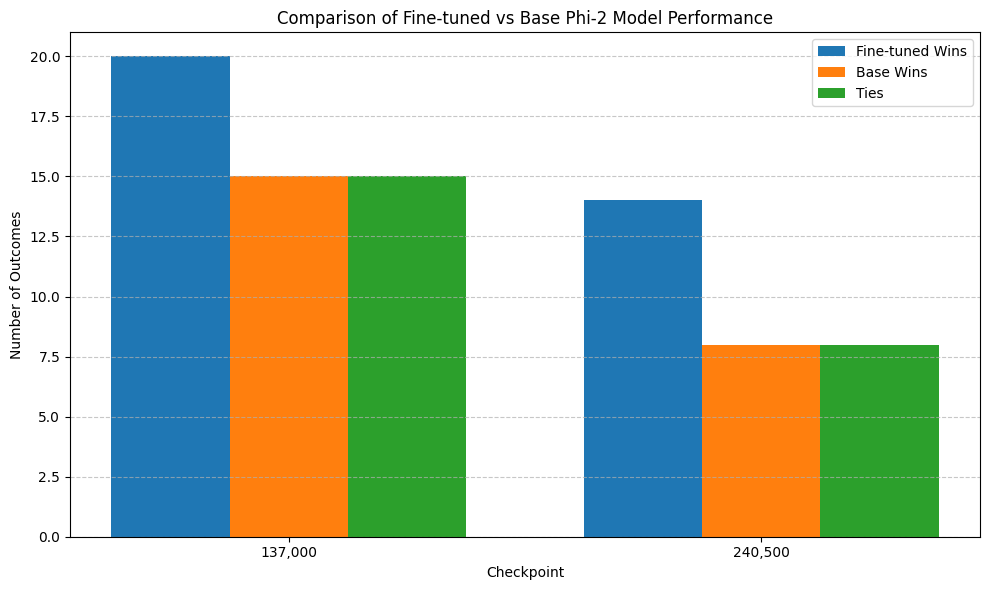

In [22]:
# Re-importing matplotlib and redefining the variables to fix the NameError
import matplotlib.pyplot as plt

# Updated data and labels
checkpoints = ["137,000", "240,500"]
fine_tuned_wins = [20, 14]
base_wins = [15, 8]
ties = [15, 8]

# Bar width and position setup
bar_width = 0.25
r1 = range(len(checkpoints))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]

# Plotting
plt.figure(figsize=(10, 6))
plt.bar(r1, fine_tuned_wins, width=bar_width, label="Fine-tuned Wins")
plt.bar(r2, base_wins, width=bar_width, label="Base Wins")
plt.bar(r3, ties, width=bar_width, label="Ties")

# Labels and titles
plt.xlabel("Checkpoint")
plt.ylabel("Number of Outcomes")
plt.title("Comparison of Fine-tuned vs Base Phi-2 Model Performance")
plt.xticks([r + bar_width for r in range(len(checkpoints))], checkpoints)
plt.legend()
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()
